In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA
import tensorflow as tf
from sklearn.decomposition import PCA

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import make_h_all, PC_axes, get_T_inds, make_dendro, gen_trials_from_model_dir

In [2]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','online_figs','fig5','fig5_ADGJMP')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [3]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_set_names = ['DelayPro', 'ReactPro', 'MemoryPro', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'IntegrationModality1', 'IntegrationModality2', 'ContextIntModality1', 'ContextIntModality2', 'IntegrationMultimodal',
              'ReactMatch2Sample', 'ReactNonMatch2Sample', 'ReactCategoryPro', 'ReactCategoryAnti']

m = '/Users/lauradriscoll/Documents/data_share/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1'


In [4]:
def make_label_sets(rule_trains):
    
    rule_trains_random = np.random.permutation(rule_trains)
    print(rule_trains_random)
    
    label_set = {}
    label_set['Anti'] = [('anti' in rule) for rule in rule_trains]
    label_set['Delay'] = [('delay' in rule) or ('fd' in rule) for rule in rule_trains]
    label_set['Contin Mem.'] = [('delay' in rule) for rule in rule_trains]
    label_set['Cat Mem.'] = ['dmc' in rule for rule in rule_trains]
    label_set['Modality2'] = ['dm2' in rule for rule in rule_trains]
    label_set['Modality1'] = ['dm1' in rule for rule in rule_trains]
    label_set['Random2'] = ['dm2' in rule for rule in rule_trains_random]
    label_set['Random3'] = ['anti' in rule for rule in rule_trains_random]
    label_set['Random9'] = [('delay' in rule) or ('fd' in rule) for rule in rule_trains_random]

    label_reverse_set = {}
    label_reverse_set['Anti'] = ~np.array(label_set['Anti'])
    label_reverse_set['Delay'] = ~np.array(label_set['Delay'])
    label_reverse_set['Contin Mem.'] = label_set['Cat Mem.']
    label_reverse_set['Cat Mem.'] = label_set['Contin Mem.']
    label_reverse_set['Modality2'] = ['dm1' in rule for rule in rule_trains]
    label_reverse_set['Modality1'] = ['dm2' in rule for rule in rule_trains]
    label_reverse_set['Random2'] = ['dm1' in rule for rule in rule_trains_random]
    label_reverse_set['Random3'] = ~np.array(label_set['Random3'])
    label_reverse_set['Random9'] = ~np.array(label_set['Random9'])
    return label_set, label_reverse_set

In [5]:
label_set,label_reverse_set = make_label_sets(rule_trains)

['reactanti' 'contextdelaydm2' 'fdgo' 'fdanti' 'dmcnogo' 'delayanti'
 'multidelaydm' 'reactgo' 'dmcgo' 'contextdelaydm1' 'dmsgo' 'dmsnogo'
 'delaydm2' 'delaygo' 'delaydm1']


In [6]:
import matplotlib.patches as mpatches
from scipy.cluster import hierarchy
color_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                 '#e41a1c', '#dede00']
hierarchy.set_link_color_palette(color_palette)
alphabet = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i', 10:'j', 11:'k', 12:'l', 13:'m', 14:'n', 15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t', 21:'u', 22:'v', 23:'w', 24:'x', 25:'y', 26:'z'}

In [7]:
lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
save_dir = os.path.join(m,lesion_folder)

cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
lesion_var = np.load(os.path.join(save_dir,'lesion_var.npz'))

perfs_changes = lesion_var['perfs_changes']

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


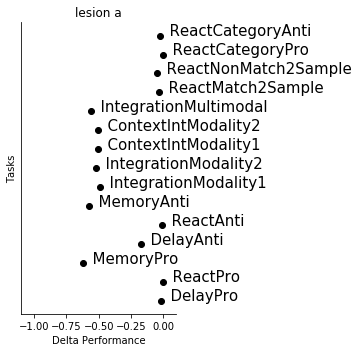

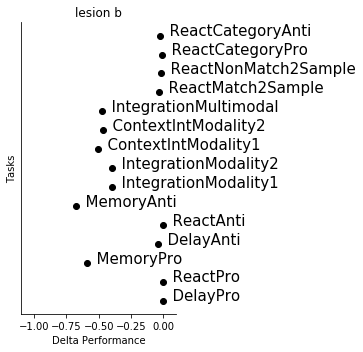

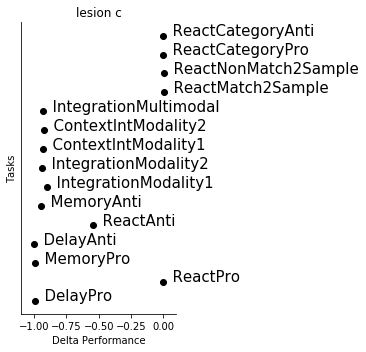

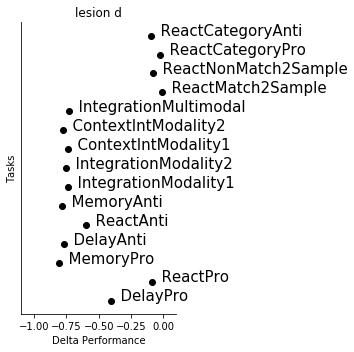

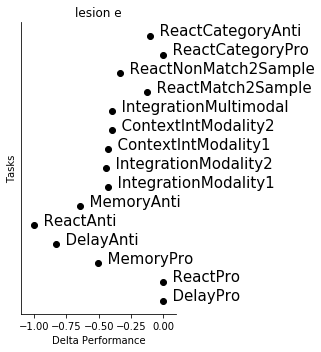

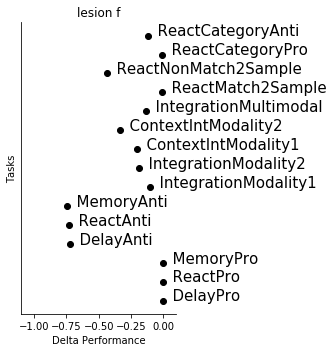

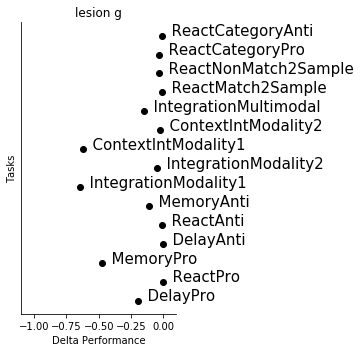

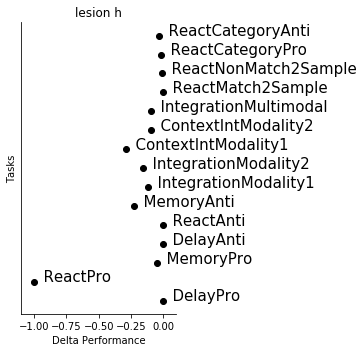

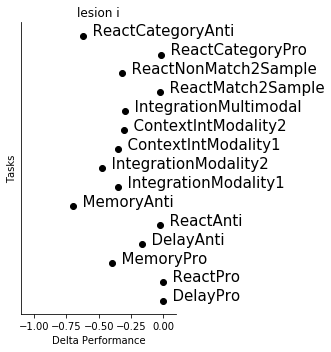

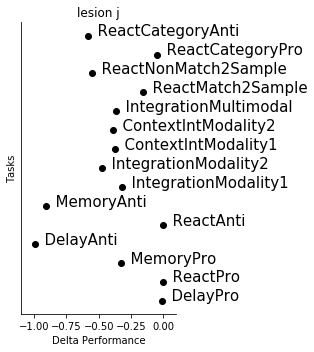

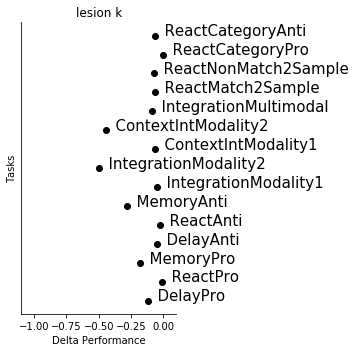

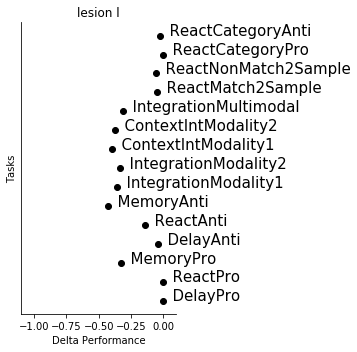

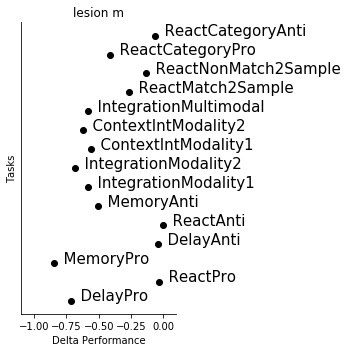

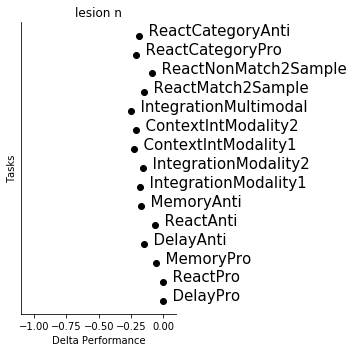

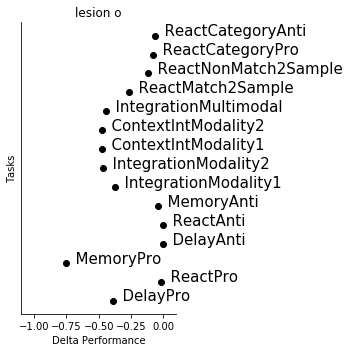

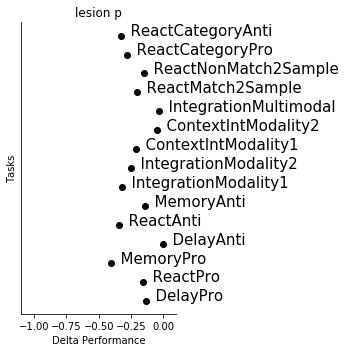

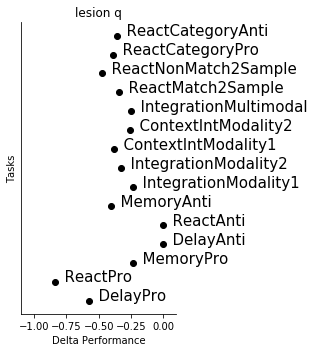

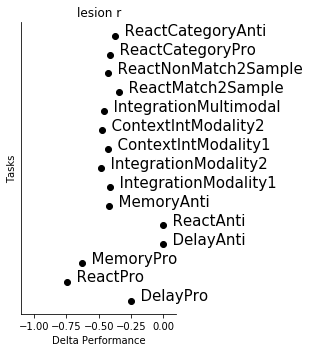

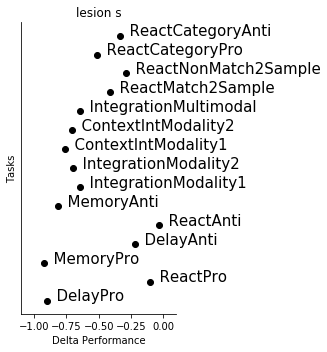

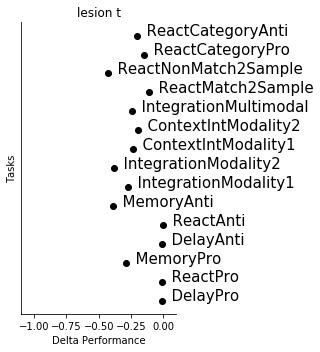

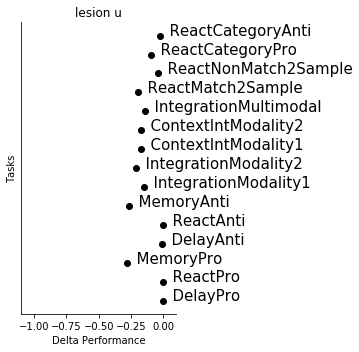

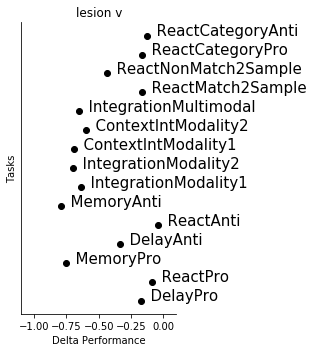

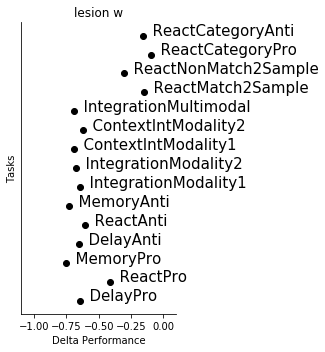

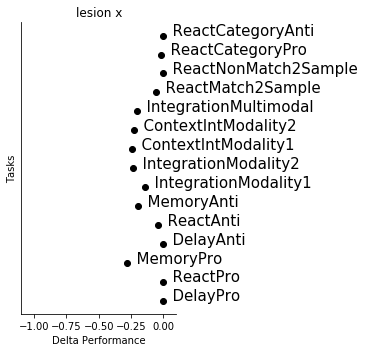

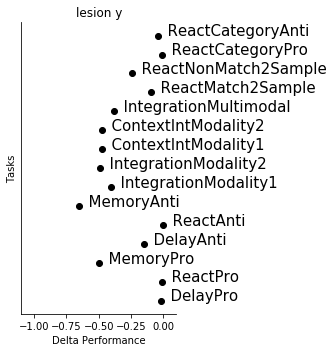

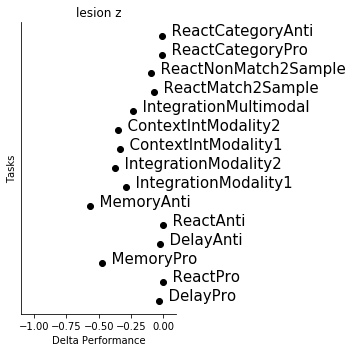

In [8]:
for l in range(len(perfs_changes)):
    fig = plt.figure(figsize=(5,5),tight_layout=True,facecolor='white')
    ax = plt.subplot(121)
#     ax2 = plt.subplot(122)
    for y in range(15):
        plt.text(perfs_changes[l,y],y,'  '+rule_set_names[y],fontsize = 15)
        plt.plot(perfs_changes[l,y],y,'ok')
    plt.xlim((-1.1,.1))
    plt.title('lesion '+ alphabet[l+1])
    plt.xlabel('Delta Performance')
    plt.ylabel('Tasks')
    plt.yticks([])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    figname = 'perf_change'+'_lesion_'+ alphabet[l+1]
    plt.savefig(os.path.join(figpath,figname+'.pdf'),bbox_inches='tight')
    
    plt.show()

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


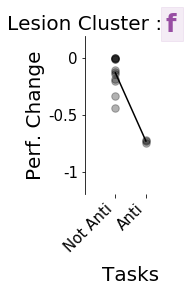

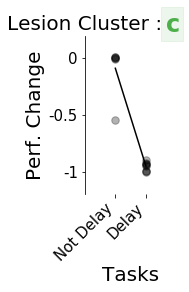

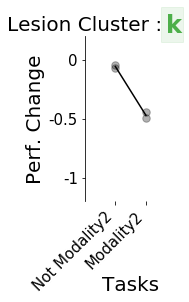

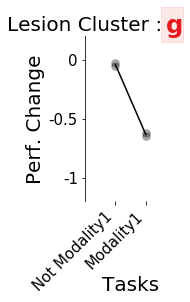

In [9]:
cluster_number = {}
cluster_number['Anti'] = 5
cluster_number['Delay'] = 2
cluster_number['Modality2'] = 10
cluster_number['Modality1'] = 6
cluster_names = ['Anti','Delay','Modality2','Modality1']

# cluster_number['Cat Mem.'] = 12
# cluster_number['Contin Mem.'] = 0
# cluster_names = ['Cat Mem.','Contin Mem.']

save_dir = os.path.join(figpath,'lesion_clusters_combined')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
fontsize = 20
tick_fontsize = fontsize*.75
label_fontsize = fontsize*1
plt.rcParams.update({'font.size': fontsize})

for key_i in range(len(cluster_number.keys())):
    
    fig = plt.figure(figsize=(3,4.5),tight_layout=True,facecolor='white')
    ax = plt.subplot(111)
    
    key = cluster_names[key_i]

    perfs_change_cluster = perfs_changes[cluster_number[key],:]

    len_key = np.sum(label_set[key])
    plt.plot(np.ones(len_key),perfs_change_cluster[label_set[key]],
             '.k',markersize = 15,alpha = .3)

    len_key = np.sum(label_reverse_set[key])
    plt.plot(np.zeros(len_key),perfs_change_cluster[label_reverse_set[key]],
             '.k',markersize = 15,alpha = .3)
    
    plt.plot([1,0],[np.mean(perfs_change_cluster[label_set[key]]),
                                                 np.mean(perfs_change_cluster[label_reverse_set[key]])],'-k')

    plt.ylabel('Perf. Change',fontsize = fontsize)
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Not '+key,key],rotation = 45,ha = 'right',fontsize = tick_fontsize)
    ax.set_yticks([0,-.5,-1])
    ax.set_yticklabels([0,-.5,-1],fontsize = tick_fontsize)
    plt.xlabel('Tasks',fontsize = fontsize)
    ax.xaxis.set_label_coords(.5, -.45)
    plt.title('Lesion Cluster :',fontsize = fontsize, color = 'k',x=0)
    
    #color lesion letter
    text_xloc = 1.5
    text_yloc = .15
    xi = cluster_number[key]+1
    c = color_palette[(xi-1)%len(color_palette)]
    rect=mpatches.Rectangle((text_xloc,text_yloc),.7,.3, 
    fill=True,
    color=c,facecolor=c,alpha = .1,clip_on=False)
    plt.gca().add_patch(rect)
    plt.text(text_xloc*1.1,text_yloc+.08,alphabet[xi],color =c,fontweight='bold',rotation = 0,fontsize = 24)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
#         ax.set_xticks([])
    plt.ylim([-1.2,.2])
    plt.xlim([-1,2])

    figname = 'perf_change_'+key
    plt.savefig(os.path.join(figpath,figname+'.pdf'),bbox_inches='tight')